In [18]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [20]:
import os
#path = '/kaggle/input/dog-breed-image-dataset/dataset'
path = '/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatImgClassifier/data/extracted/dataset/train'
dirs = os.listdir(path)
print(dirs)

['Rottweiler', 'Dachshund', 'Yorkshire_Terrier', 'Beagle', 'Golden_Retriever', 'Poodle', 'Labrador_Retriever', 'German_Shepherd', 'Boxer', 'Bulldog']


In [21]:
! pip install pandas

In [22]:
import pandas as pd
from tqdm import tqdm
X = []
Y = []
for cls in tqdm(dirs):
    imgs = os.listdir(path + '/' + cls)
    for img in imgs:
        if (img == '.ipynb_checkpoints'):
            continue
        X.append(path + '/' + cls + '/' + img)
        Y.append(cls)

100%|██████████| 10/10 [00:00<00:00, 2909.88it/s]


In [23]:
df = pd.DataFrame({'image':X, 'class':Y})
df = df.sample(frac=1)
df.head()

,image,class
141,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,Dachshund
179,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,Yorkshire_Terrier
643,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,Boxer
548,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,German_Shepherd
607,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,Boxer


In [24]:
! pip install matplotlib

torch.Size([3, 108, 162])


/var/folders/25/vqnx0dh53y7clwgprnzshhxr0000gn/T/ipykernel_42692/2329653951.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_img = torchvision.io.read_image(df.iloc[idx][0])


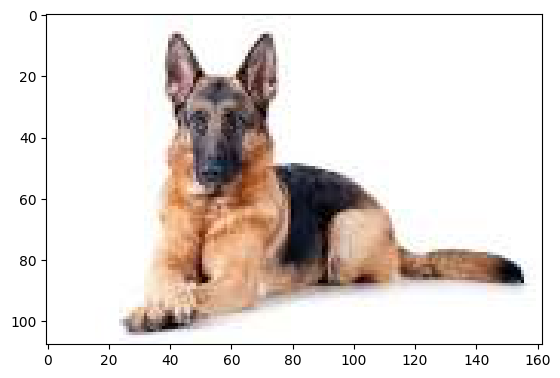

In [25]:
import torchvision
import random
idx = random.randint(0, len(df))
test_img = torchvision.io.read_image(df.iloc[idx][0])

from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(test_img.permute(1, 2, 0))
print(test_img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


torch.Size([3, 224, 224])


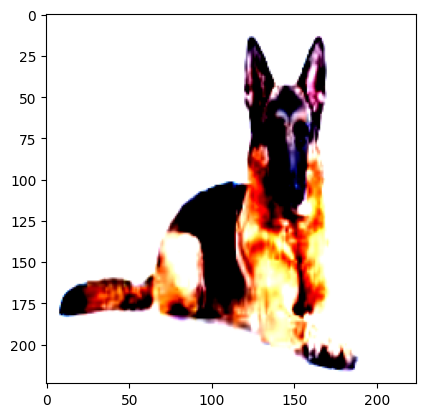

In [26]:
from torchvision.transforms import v2
transforms = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_img = transforms(test_img)
print(test_img.shape)
plt.imshow(test_img.permute(1, 2, 0))

In [27]:
ohe_df = pd.get_dummies(df, columns=['class'], dtype=int)
ohe_df.head()

,image,class_Beagle,class_Boxer,class_Bulldog,class_Dachshund,class_German_Shepherd,class_Golden_Retriever,class_Labrador_Retriever,class_Poodle,class_Rottweiler,class_Yorkshire_Terrier
141,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,0,0,0,1,0,0,0,0,0,0
179,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,0,0,0,0,0,0,0,0,0,1
643,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,0,1,0,0,0,0,0,0,0,0
548,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,0,0,0,0,1,0,0,0,0,0
607,/Users/vehere/mlworks/EMLO4/code/EMLO4/DogCatI...,0,1,0,0,0,0,0,0,0,0


ResNet 18 code taken from https://medium.com/analytics-vidhya/resnet-understand-and-implement-from-scratch-d0eb9725e0db

In [28]:
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # Final Block input=(7x7) 
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END
    
    def forward(self, x):
        
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
    
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        
        
        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)

        
        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_1(self.conv5_2_1(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)


        # FINAL BLOCK - classifier 
        x = self.avgpool(op5)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.out(x)

        return x

In [29]:
model = ResNet18(10)
model.to(device)

ResNet18(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_1): Dropout(p=0.5, inplace=False)
  (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_2): BatchNo

In [30]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class DatasetDogs(Dataset):
    def __init__(self, df, transform=None, device='cpu'):
        self.img_data = df
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        row = self.img_data.iloc[idx].to_numpy()
        image = read_image(row[0])
        label = torch.zeros(10, dtype=torch.float)
        for i in range(1, 11):
            label[i - 1] = row[i]
        if self.transform:
            image = self.transform(image)
        image = image.to(self.device)
        label = label.to(self.device)
        return image, label

In [31]:
from tqdm import tqdm
from torch.utils.data import DataLoader

val_count = int(0.15 * len(ohe_df))
test_count = int(0.15 * len(ohe_df))
train_count = len(ohe_df) - val_count - test_count

bs = 2
train_dataloader = DataLoader(DatasetDogs(ohe_df.head(train_count), transforms, device),
                             batch_size=bs, shuffle=True)

val_dataloader = DataLoader(DatasetDogs(ohe_df.tail(val_count), transforms, device),
                           batch_size=bs, shuffle=True)

test_dataloader = DataLoader(DatasetDogs(ohe_df.tail(test_count), transforms, device),
                           batch_size=bs, shuffle=True)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-4) 
epochs = 5
t_loss = []
t_acc = []
v_loss = []
v_acc = []
softmax = nn.Softmax(dim = 1)
model.train()
for i in range(epochs):
    print('Epoch ' + str(i + 1) + ':')
    loss_acc = 0
    acc = 0
    pbar = tqdm(train_dataloader)
    for img, label in pbar:
        op = model(img)
        loss = criterion(op, label)
        loss_acc = loss_acc + abs(loss.detach().item()) 
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        for j,k in zip(softmax(op).argmax(dim = 1), label.argmax(dim = 1)):
            if (j == j):
                acc = acc + 1
                
        pbar.set_description("loss: " + str(loss.item()))
        
    sample_count = len(train_dataloader) * bs
    train_loss = loss_acc / sample_count
    train_acc = acc / sample_count
    loss_acc = 0
    acc = 0
    pbar = tqdm(val_dataloader)
    for img, label in pbar:
        op = model(img)
        loss = criterion(op, label)
        loss_acc = loss_acc + abs(loss.detach().item())
        
        for j,k in zip(softmax(op).argmax(dim = 1), label.argmax(dim = 1)):
            if (j == j):
                acc = acc + 1
                
        pbar.set_description("loss: " + str(loss.item()))
        
    sample_count = len(val_dataloader) * bs
    val_loss = loss_acc / sample_count
    val_acc = acc / sample_count
    
    print('train loss: ' + str(train_loss))
    print('val loss: ' + str(val_loss))
    print('train Accuracy: ' + str(train_acc))
    print('val Accuracy: ' + str(val_acc))
    
    t_loss.append(train_loss)
    v_loss.append(val_loss)
    t_acc.append(train_acc)
    v_acc.append(val_acc)
model.eval()

Epoch 1:


loss: 2.5946078300476074: 100%|██████████| 57/57 [00:30<00:00,  1.90it/s]


train loss: 1.1789497688131512
val loss: 1.1828705176972507
train Accuracy: 1.0
val Accuracy: 0.9912280701754386
Epoch 2:


loss: 2.175769567489624: 100%|██████████| 57/57 [00:31<00:00,  1.78it/s] 


train loss: 1.131640155585307
val loss: 1.1459775671624302
train Accuracy: 1.0
val Accuracy: 0.9912280701754386
Epoch 3:


loss: 2.1135542392730713: 100%|██████████| 57/57 [00:34<00:00,  1.67it/s]


train loss: 1.1117740372441849
val loss: 1.118679189891146
train Accuracy: 1.0
val Accuracy: 0.9912280701754386
Epoch 4:


loss: 2.2523980140686035: 100%|██████████| 57/57 [00:38<00:00,  1.48it/s]


train loss: 1.0874172505342736
val loss: 1.0954317074072988
train Accuracy: 1.0
val Accuracy: 0.9912280701754386
Epoch 5:


loss: 2.2724013328552246: 100%|██████████| 57/57 [00:31<00:00,  1.83it/s]

train loss: 1.0719962097563833
val loss: 1.078820973111872
train Accuracy: 1.0
val Accuracy: 0.9912280701754386


ResNet18(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_1): Dropout(p=0.5, inplace=False)
  (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_2): BatchNo

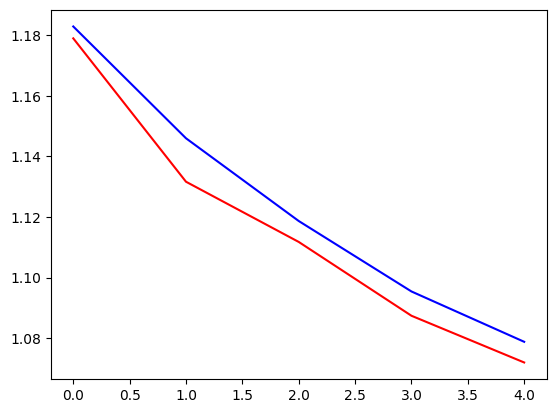

In [32]:
plt.plot(range(len(t_loss)), t_loss, color='r')

plt.plot(range(len(v_loss)), v_loss, color='b')

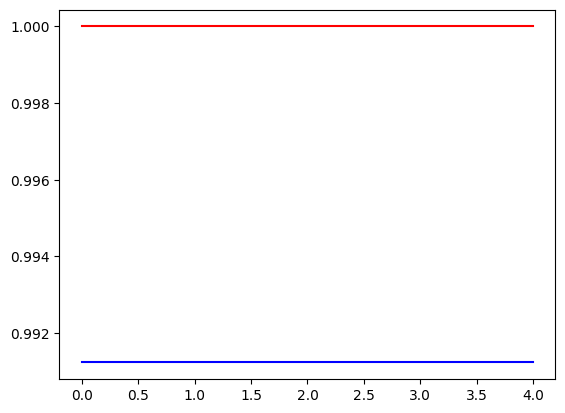

In [33]:
plt.plot(range(len(t_acc)), t_acc, color='r')
plt.plot(range(len(v_acc)), v_acc, color='b')

In [34]:
pbar = tqdm(test_dataloader)
acc = 0
for img, label in pbar:
    op = model(img)      
    for j,k in zip(softmax(op).argmax(dim = 1), label.argmax(dim = 1)):
        if (j == j):
            acc = acc + 1
            
    pbar.set_description("loss: " + str(loss.item()))
print("test_accuracy: " + str(acc / (len(test_dataloader) * bs)))

loss: 2.2724013328552246: 100%|██████████| 57/57 [00:25<00:00,  2.28it/s]

test_accuracy: 0.9912280701754386


/var/folders/25/vqnx0dh53y7clwgprnzshhxr0000gn/T/ipykernel_42692/3138528890.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_img = torchvision.io.read_image(df.iloc[idx][0])
/var/folders/25/vqnx0dh53y7clwgprnzshhxr0000gn/T/ipykernel_42692/3138528890.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + "actual: " + df.iloc[idx][1], fontsize=6)


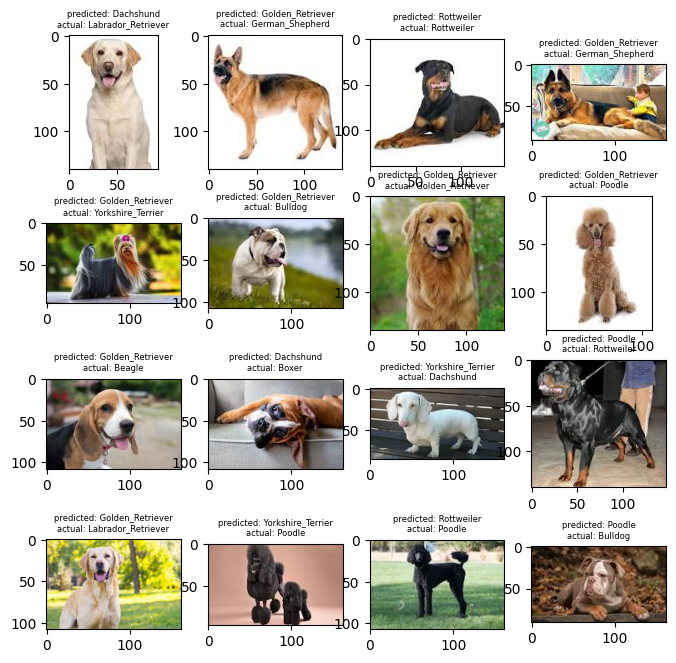

In [35]:
plt.figure(figsize = (8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    idx = random.randint(0, len(df))
    test_img = torchvision.io.read_image(df.iloc[idx][0])
    ip_img = transforms(test_img)[None, :]
    pred = softmax(model(ip_img.to(device)))
    
    plt.imshow(test_img.permute(1, 2, 0).cpu())
    plt.title("predicted: " + ohe_df.columns[pred[0].argmax().item() + 1][6:] + "\n"
             + "actual: " + df.iloc[idx][1], fontsize=6)